# ImpDAR NMO Filter Tutorial (Variable Velocity)

The normal move-out filter corrects for source-receiver antenna separation by finding the legs of the triangular travel path. Within ImpDAR, this filter also converts from two-way-travel-time to depth. Both the filter and the depth conversion account for variable wave speed when requested.

Here, we walk through an example using ground-based snow radar from South Cascade Glacier. Density cores drilled in the snowpack are used to constrain the wave speed.

In [1]:
# Load standard libraries
import numpy as np
import matplotlib.pyplot as plt
from impdar.lib import load
# To make the plots look nicer
plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

Load the raw data (PulseEKKO format) and do some initial processecing steps (vertical bandpass and pretrigger crop) before considering the nmo filter.

Bandpassing from 250.0 to 750.0 MHz...
Bandpass filter complete.
Vertical samples reduced to subset [317:3000] of original


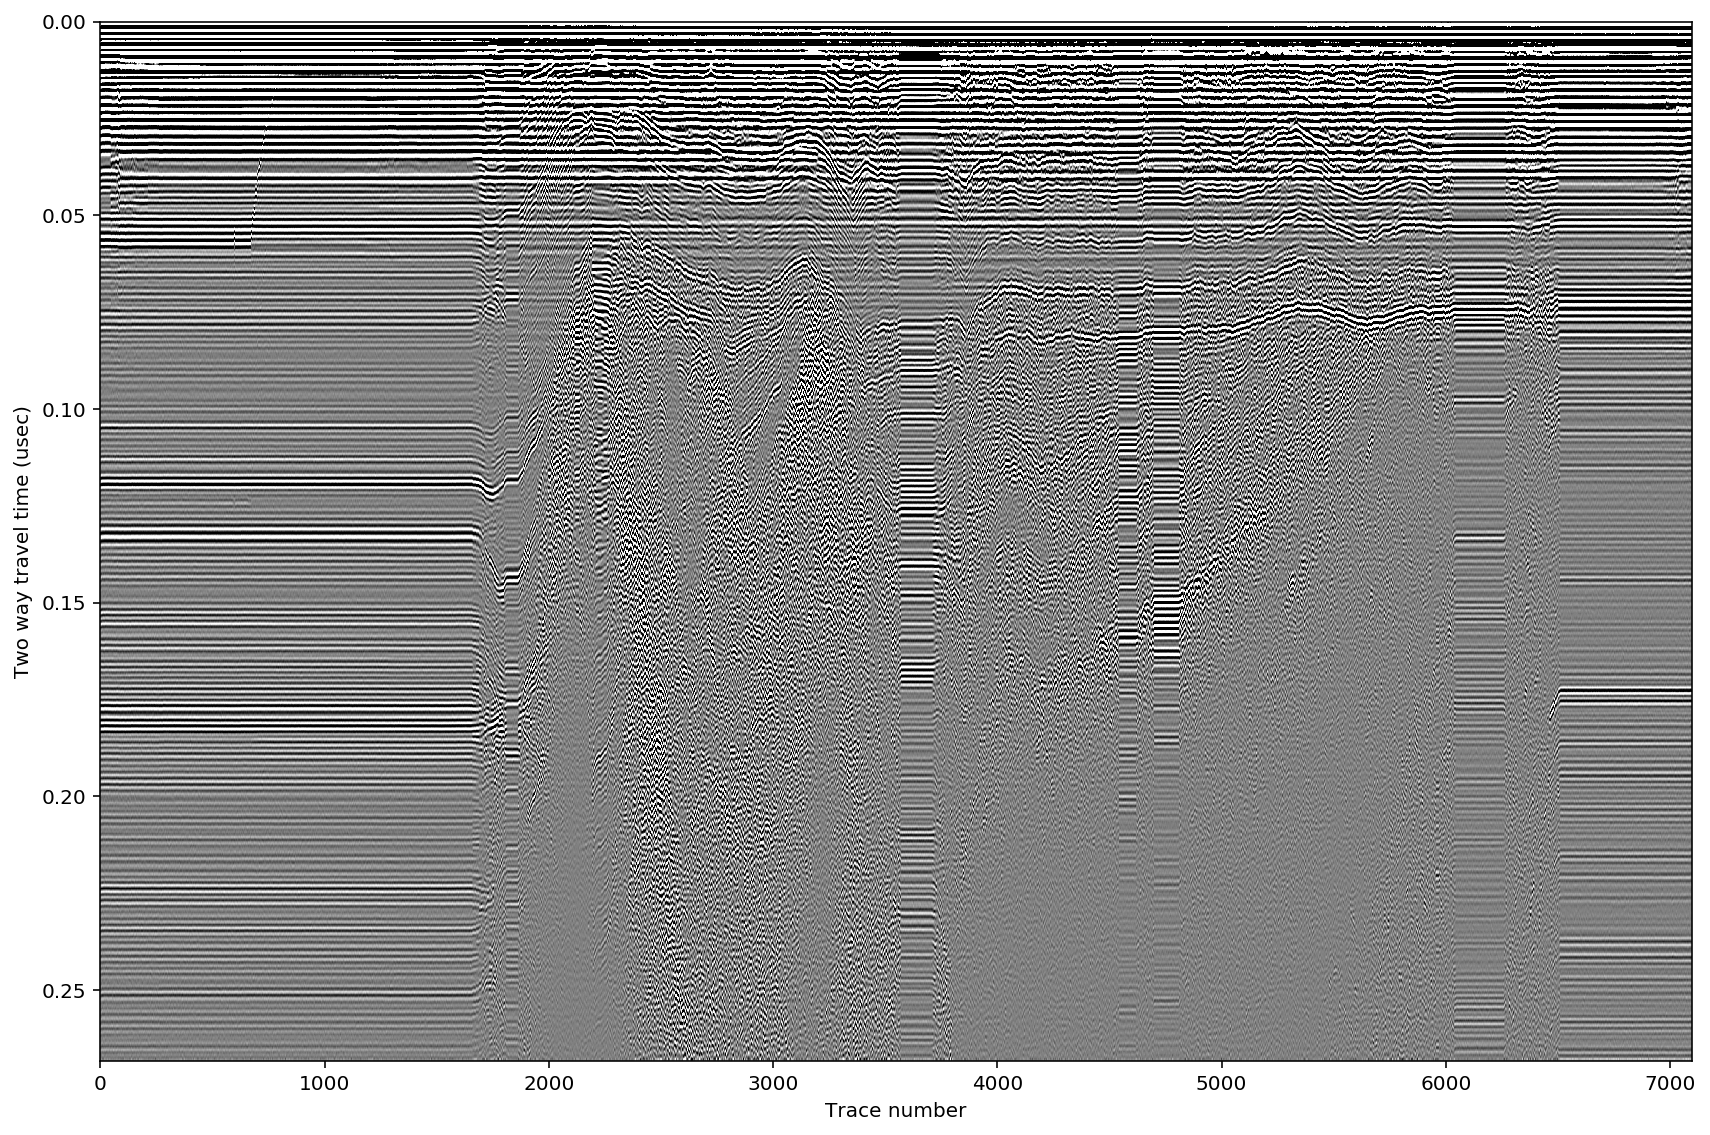

In [2]:
# Load the Pulse EKKO data
dat = load.load('pe',['data/LINE01.DT1'])[0]
# Bandpass filter
dat.vertical_band_pass(250,750)
# Crop the pretrigger
dat.crop(0.,dimension='pretrig',rezero=True)

# Plot the 
from impdar.lib.plot import plot
%matplotlib inline
dat.save('./scg_data_raw.mat')
plot('./scg_data_raw.mat')

### Get permittivity and wave-speed profile

The speed of light in ice is density-dependent, it travels faster in lower density snow/firn/ice which makes sense because that is closer to air. ImpDAR has some functionality to convert from snow/firn density to permittivity (wave speed). Here, we load the density profile measured at South Cascade Glacier and convert that to permittivity and subsequently to wave speed.

At every reflector depth for the correction, the nmo filter uses a root-mean-square wave speed to calculate the time between the two antennas. This is one leg of the triangle, the recorded time is the hypoteneuse, and the second leg is the vertical time that we really want.

/Users/dlilien/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


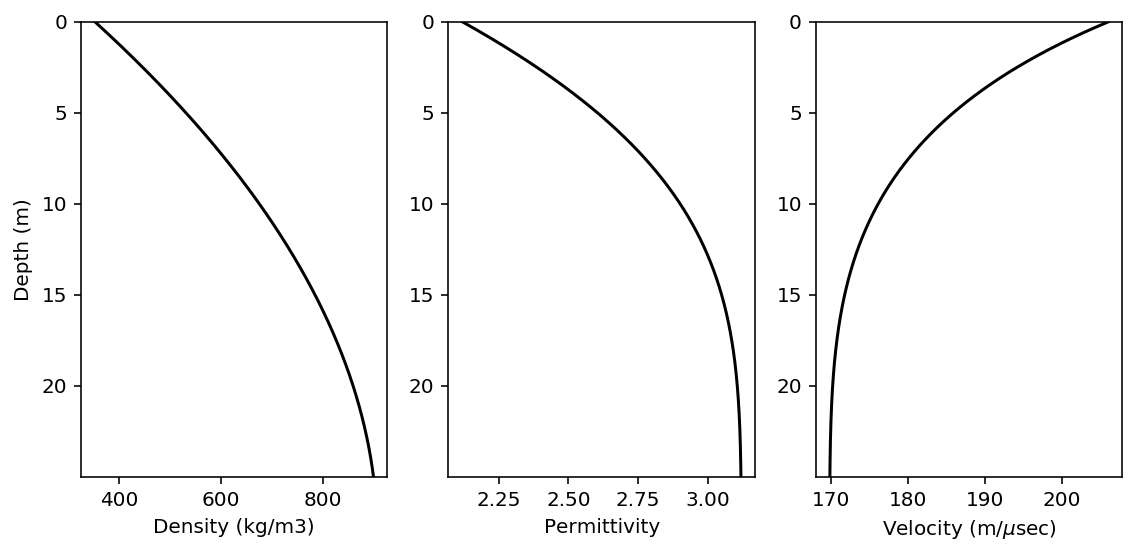

In [3]:
# load the density-to-permittivity function from ImpDAR
from impdar.lib.permittivity_models import firn_permittivity

# Load data from the density core at South Cascade Glacier
rho_profile_data = np.genfromtxt('2018_density_profile.csv',delimiter=',')
profile_depth = rho_profile_data[:,0]
profile_rho = rho_profile_data[:,1]
# speed of light in vacuum
c = 300.
# convert density to profile velocity
profile_vel = c/np.sqrt(np.real(firn_permittivity(profile_rho)))

# Plot a figure to show density, permittivity, and velocity profiles
plt.figure(figsize=(8,4))

ax1 = plt.subplot(131)
plt.ylabel('Depth (m)')
plt.xlabel('Density (kg/m3)')
plt.plot(profile_rho,profile_depth,'k')
plt.ylim(max(profile_depth),0)

ax2 = plt.subplot(132)
plt.xlabel('Permittivity')
plt.plot(firn_permittivity(profile_rho),profile_depth,'k')
plt.ylim(max(profile_depth),0)

ax3 = plt.subplot(133)
plt.xlabel('Velocity (m/$\mu$sec)')
plt.plot(profile_vel,profile_depth,'k')
plt.ylim(max(profile_depth),0)

plt.tight_layout()
plt.draw()

### NMO Correction

Finally, do the nmo correction. This correction stretches samples near the surface, so a 1-dimensional interpolation is done afterward to get equal depth sampling. 

You will notice that the corrected times are longer than the uncorrected times. This is because the raw times are measured at the reciever. Really though, we need the times relative to the transmit pulse for the correction. The time for the initial pulse to get to the antennae is added to the measured time to get the transmitted time and that is corrected to get the vertical leg of the triangle (the final nmo time).

/Users/dlilien/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dlilien/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dlilien/work/sw/impdar/impdar/impdar/lib/RadarData/_RadarDataProcessing.py:186: RuntimeWarning: invalid value encountered in sqrt
  return abs(np.sqrt((t/2.*u_rms)**2.-ant_sep**2.)-d_in)


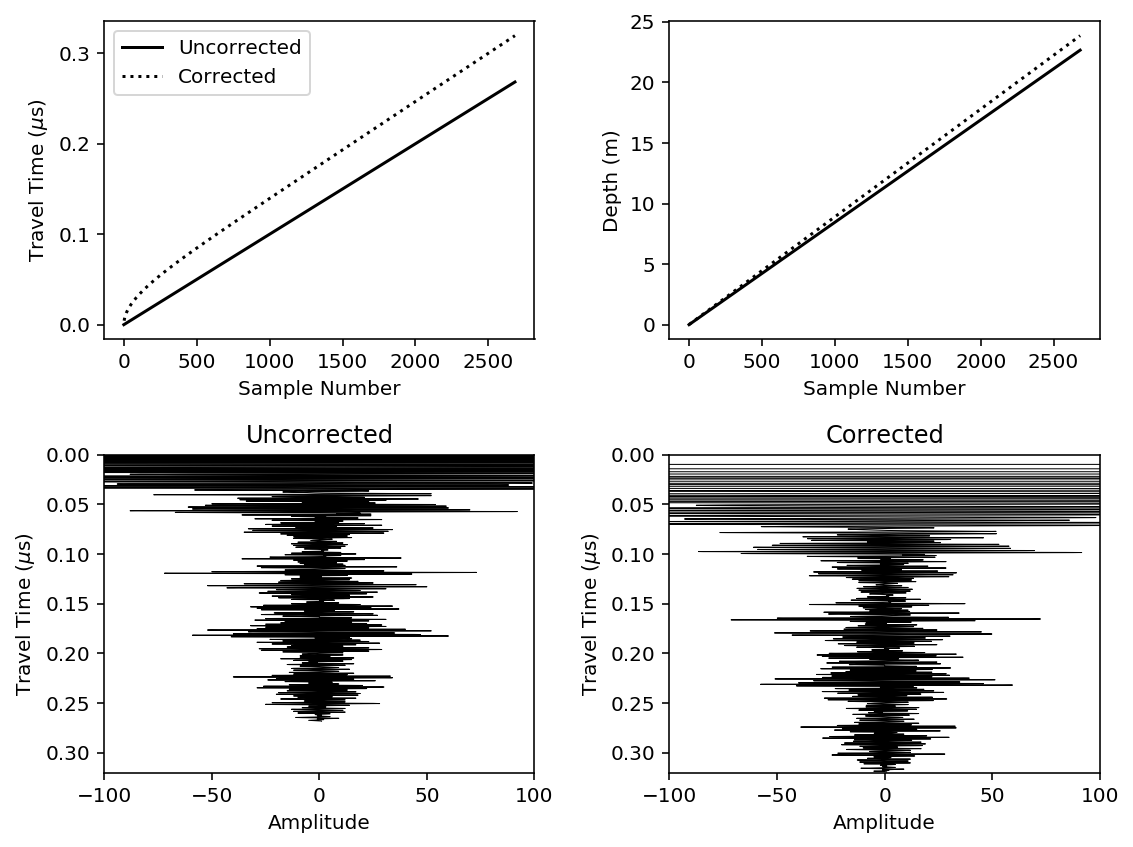

In [4]:
# Plot a figure before and after the correction
plt.figure(figsize=(8,6))

ax1 = plt.subplot(221)
ax1.plot(dat.travel_time,'k',label='Uncorrected')
plt.xlabel('Sample Number')
plt.ylabel('Travel Time ($\mu$s)')
ax2 = plt.subplot(222)
ax2.plot(dat.travel_time/2.*169,'k')
plt.xlabel('Sample Number')
plt.ylabel('Depth (m)')

ax3 = plt.subplot(223)
plt.plot(dat.data[:,400],dat.travel_time,'k',lw=0.5)
plt.xlim(-100,100)
plt.ylim(0.32,0.0)
plt.ylabel('Travel Time ($\mu$s)')
plt.xlabel('Amplitude')
plt.title('Uncorrected')

# ---------------------

# NMO correction
# 10 m is an overestimate of the antenna separation in this case
# but it is useful to understand what is going on
dat.nmo(10.,rho_profile='2018_density_profile.csv')

# ---------------------

ax1.plot(dat.travel_time,'k:',label='Corrected')
ax1.legend()
ax2.plot(dat.nmo_depth,'k:')

ax4 = plt.subplot(224)
plt.plot(dat.data[:,400],dat.travel_time,'k',lw=0.5)
plt.xlim(-100,100)
plt.ylim(0.32,0.0)
plt.ylabel('Travel Time ($\mu$s)')
plt.xlabel('Amplitude')
plt.title('Corrected')

plt.tight_layout()
plt.show()